In [1]:
# basics
import pandas as pd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# fetching light curves
from lightkurve import search_lightcurvefile, search_targetpixelfile

# units and constants
import astropy.units as u
from astropy.constants import R_sun, M_sun

# data management
import os
CWD = "/".join(os.getcwd().split("/")[:-2])

In [2]:
df = pd.read_csv(f"{CWD}/data/gaia/flare_candidates.csv")

In [27]:
gdf = pd.read_csv(f"{CWD}//data/gaia/crossmatch_5_arcsec.csv")

In [ ]:
select = df[df.ampl_rec>0.2]
select_ticsec = select[["TIC","Sector"]].drop_duplicates()

In [ ]:
select_ticsec.shape

In [ ]:
select = pd.DataFrame({"TIC":[237880881, 44984200, 277539431],
                       "Sector":[1,8,12]})

In [ ]:
def get_snr_periodogram(TIC, sec):
    TIC = int(TIC)
    sec = int(sec)

    lc = search_lightcurvefile(f"TIC {TIC}",sector=sec,cadence="short", ).download(
                               download_dir="/home/ekaterina/Documents/001_science/TESS_UCD_flares/lcs")

    lc = lc.get_lightcurve("PDCSAP_FLUX")

    per = lc.remove_nans().to_periodogram(minimum_period=0.05, maximum_period=1.).flatten()
    snr, period = per.max_power.value, per.period_at_max_power.value
    print(TIC, sec, snr, period)
    with open(f"{CWD}/data/gaia/lombscargle.csv","a") as f:
        f.write(fr"{TIC},{sec},{snr},{period}")
        f.write("\n")
    return snr, period
#     print(snr)
#     per.flatten().plot(view="period")

In [ ]:
res = select_ticsec.apply(lambda x: get_snr_periodogram(x.TIC, x.Sector), axis=1)

# Read in lomb scargle periodograms for each LC and merge with flares

In [23]:
lomb = pd.read_csv(f"{CWD}/data/gaia/lombscargle.csv")

In [ ]:
selectlomb = select.merge(lomb, how="left", on=["TIC","Sector"])

In [ ]:
# select high SNR, short period, and first two Cycles
selectlomb_snr = selectlomb[(selectlomb.snr > 2.) & 
                            (selectlomb.period < .5)  & 
                            (selectlomb.Sector < 27)].sort_values(by="TIC")

In [ ]:
# selectlomb_snr.to_csv(f"{CWD}/data/gaia/fastrot_largeflares.csv")

# for each row, inspect the light curves manually

In [3]:
selectlomb_snr = pd.read_csv(f"{CWD}/data/gaia/fastrot_largeflares.csv")

NameError: name 'CWD' is not defined

In [54]:
row = selectlomb_snr.iloc[0]

#,observation,target_name,productFilename,distance
0,TESS Sector 7,452922110,tess2019006130736-s0007-0000000452922110-0131-s_lc.fits,0.0


In [42]:
# plot all flares for a light curve at once
TIC, sec = int(row.TIC), int(row.Sector)
sdf = selectlomb_snr[(selectlomb_snr.TIC == TIC) & (selectlomb_snr.Sector==sec)]
lc = search_lightcurvefile(f"TIC {TIC}",sector=sec,cadence="short", ).download(
                                   download_dir="/home/ekaterina/Documents/001_science/TESS_UCD_flares/lcs")
lc = lc.get_lightcurve("PDCSAP_FLUX")

for i, row in sdf.iterrows():
    fig, ax = plt.subplots(figsize=(16,5))
    ax.plot(lc.time, lc.flux, label=f"TIC {TIC}, S{sec}")
    ax.set_xlim(1430, 1434)
    plt.ylim(3650,4350)
    plt.xticks(fontsize=16)
    plt.xlabel("time in days", fontsize=16)
    plt.ylabel("flux", fontsize=16)
    plt.legend(frameon=False, fontsize=16);


(280.0, 340.0)

<Figure size 1152x288 with 0 Axes>

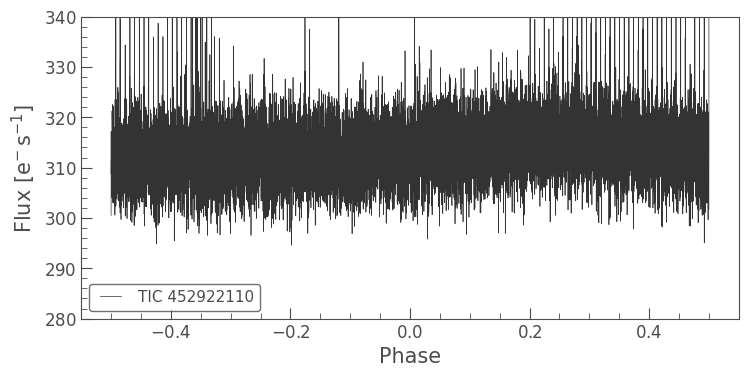

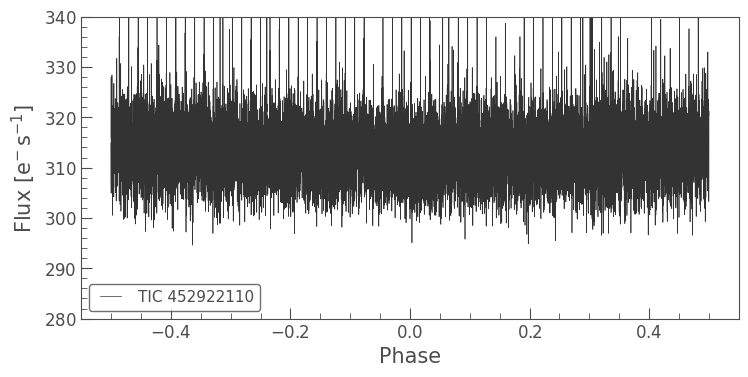

In [62]:
# phase fold if you need to check if the period is real

lc2 =lc#[(lc.time<1331) | (lc.time>1333)]
plt.figure(figsize=(16,4))
lc2.fold(period=.176454170180627, t0=1493.).plot()
plt.ylim(280,340)
# plt.xlim(-.5,.5)


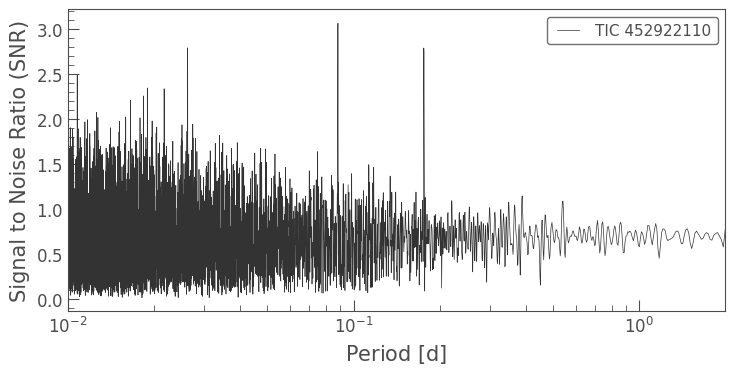

In [49]:
# plot the periodogram to check for aliases
per = lc.remove_nans().to_periodogram(minimum_period=0.01, maximum_period=2.).flatten()
snr, period = per.max_power.value, per.period_at_max_power.value

per.plot(view="period")
plt.xlim(0.01,2.)
plt.xscale("log")

In [9]:
# check targetpixelfile when in doubt
tpf = search_targetpixelfile(f"TIC {TIC}", sector=sec).download()

In [10]:
tpf.interact()